#### 사용된 데이터는 파이썬으로 배우는 통계학 교과서의 예제 소스임

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# 선형모델을 추정하는 라이브러리
import statsmodels.formula.api as smf
import statsmodels.api as sm

## 5.3 독립변수가 여럿인 모델
- 날씨라는 카테고리형 독립변수를 사용한다.
- 그 외에는 연속형 변수이다.
- 복수의 독립변수를 가지고 있어도 일반선형모델 구조를 이용, 통일적인 분석,해석,예측이 가능하다.
- 여기서는 Type-II ANOVA 검정을 설명
- 복수의 독립변수가 있을 경우 그 변수들의 유의미함을 어떻게 판정할 것인지.

In [2]:
sales = pd.read_csv('../input/lm-model/5-3-1-lm-model.csv')
sales.head()

,humidity,price,sales,temperature,weather
0,29.5,290,229.7,17.8,rainy
1,38.1,290,206.1,26.1,rainy
2,31.5,290,202.5,22.0,rainy
3,39.7,290,195.5,23.0,rainy
4,24.7,290,214.4,14.5,rainy


### 5.3.2 데이터로 그래프 그리기

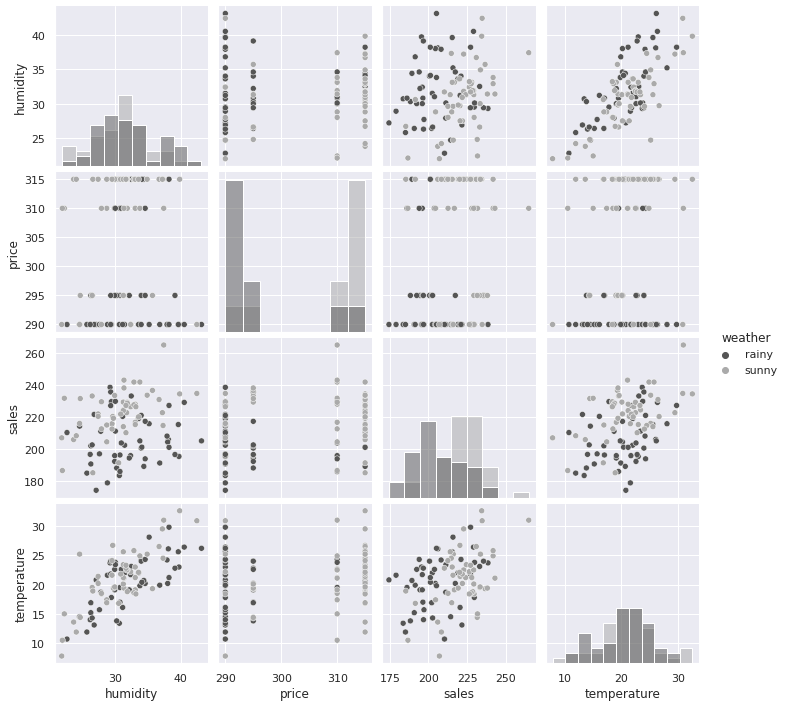

In [3]:
sns.pairplot(sales, hue='weather', palette='gray', diag_kind='hist');

그래프만 보면 온도와 습도의 상관관계가 있음을 알 수 있다.

### 5.3.3: 나쁜 분석 예: 변수가 1개인 모델 만들기

In [4]:
# 단순히 가격과 판매의 관계만을 분석해본다.
lm_dame = smf.ols('sales~price', sales).fit()
lm_dame.params

Intercept    113.645406
price          0.332812
dtype: float64

In [5]:
# 분석분석까지 해본다.
sm.stats.anova_lm(lm_dame, typ=2)

,sum_sq,df,F,PR(>F)
price,1398.392322,1.0,4.970685,0.028064
Residual,27570.133578,98.0,NaN,NaN


위 결과로 정리하면 가격이 오르면 매상도 증가한다고 생각할 수 있다.

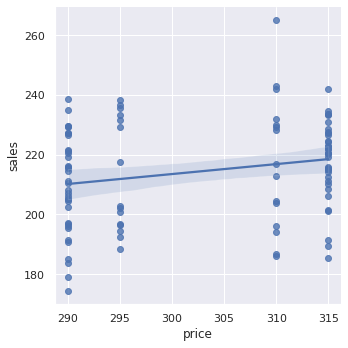

In [6]:
# 회귀직선을 봐도 가격이 오르면 매상도 오를것 같다.
sns.lmplot(x='price', y='sales', data=sales);

### 5.3.4 독립변수 간의 관계 조사하기

In [7]:
# 가게에서 매일 가격을 어떻게 바꾸는지 집계하기
sales.groupby('weather').mean()

,humidity,price,sales,temperature
weather,,,,
rainy,32.126,295.5,205.924,20.422
sunny,30.852,309.5,222.718,21.102


비오는날 매상이 떨어지기 때문에 가격을 인하했다고 생각하는 것이 자연스럽다.

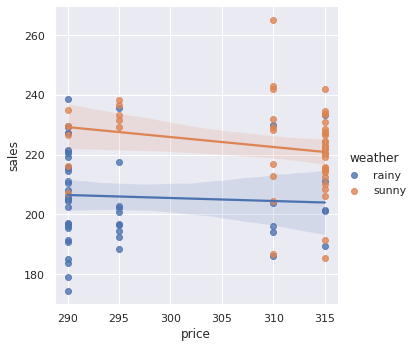

In [8]:
# 날씨가 같았을 때 상품 가격이 매상에 미치는 영향
sns.lmplot(x='price', y='sales', data=sales, hue='weather');

맑은 날과 비오는날의 데이터를 각각 사용해서 가격과 매상의 관계를 조사하면, 2번의 검정을 반복 검정의 **다중성** 문제 발생\
각 요인의 영향을 올바르게 판단하기 위해서는 **복수의 독립변수를 가지는 모델**을 *한번*에 추정해야 한다.

### 5.3.5 복수의 독립변수를 가지는 모델
- 독립변수가 4개 들어간 모델 추정

In [9]:
# 복수의 독립변수를 가진 모델 추정
lm_sales = smf.ols(formula='sales~weather+humidity+temperature+price', data=sales).fit()
lm_sales.params

Intercept           278.627722
weather[T.sunny]     19.989119
humidity             -0.254055
temperature           1.603115
price                -0.329207
dtype: float64

가격이 오르면 매출이 떨어진다는것을 알수 있다.

### 5.3.6 나쁜 분석 예: 일반적인 분산분석으로 검정하기
- 독립변수가 종속변수에 영향을 끼치고 있다고 말할 수 있는지 검정을 이용해서 판단한다.
- 이 때 평범하게 분석분석을 하는것은 문제가 있다.
 - 일반적인 분산분석 Type I ANOVA

In [10]:
sm.stats.anova_lm(lm_sales, typ=1).round(3)

,df,sum_sq,mean_sq,F,PR(>F)
weather,1.0,7050.961,7050.961,38.848,0.000
humidity,1.0,1779.601,1779.601,9.805,0.002
temperature,1.0,2076.845,2076.845,11.443,0.001
price,1.0,818.402,818.402,4.509,0.036
Residual,95.0,17242.717,181.502,NaN,NaN


위 검정결과는 모든 변수의 유의미한 것처럼 보이지만, Type I ANOVA는 독렵변수의 순서를 바꾸면 결과가 달라진다.    

In [11]:
# 복수의 독립변수를 가진 모델 추정
lm_sales_2 = smf.ols(formula='sales~weather+temperature+humidity+price', data=sales).fit()
sm.stats.anova_lm(lm_sales_2, typ=1).round(3)

,df,sum_sq,mean_sq,F,PR(>F)
weather,1.0,7050.961,7050.961,38.848,0.000
temperature,1.0,3814.779,3814.779,21.018,0.000
humidity,1.0,41.667,41.667,0.230,0.633
price,1.0,818.402,818.402,4.509,0.036
Residual,95.0,17242.717,181.502,NaN,NaN


독립변수의 순서를 바꾼 것뿐이라서 추정된 계수의 값 등은 일치하지만, 검정결과는 다르다.

### 5.3.7 회귀계수의 t검정
분산분석 대신 회귀계수의 t-test 를 하면 앞선 문제는 일어나지 않는다.

In [12]:
# 처음 검정결과
lm_sales.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,278.6277,46.335,6.013,0.000,186.641,370.615
weather[T.sunny],19.9891,3.522,5.675,0.000,12.997,26.982
humidity,-0.2541,0.456,-0.558,0.578,-1.159,0.651
temperature,1.6031,0.443,3.620,0.000,0.724,2.482
price,-0.3292,0.155,-2.123,0.036,-0.637,-0.021


In [13]:
# 독립변수의 순서를 바꾼 검정결과
lm_sales_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,278.6277,46.335,6.013,0.000,186.641,370.615
weather[T.sunny],19.9891,3.522,5.675,0.000,12.997,26.982
temperature,1.6031,0.443,3.620,0.000,0.724,2.482
humidity,-0.2541,0.456,-0.558,0.578,-1.159,0.651
price,-0.3292,0.155,-2.123,0.036,-0.637,-0.021


회귀계수의 t-test 에서는 독립변수의 순서가 문제는 발생하지 않는다.\
다만, 날씨라는 카테고리형 변수가 맑음, 비 뿐이었다.\
여기서 흐림이 있었다면 날씨의 영향을 t-test로 판단하는 것은 **검정 다중성**의 문제가 생길 것이다.

### 5.3.8 Type II ANOVA
독립변수의 순서에 따른 검정결과가 변하지 않는 분산분석을 Type II ANOVA라고 한다.

### 5.3.9 모델 선택과 분산분석
- Type I ANOVA
 - 복수의 독립변수를 가지는 경우 분산분석은 독립변수를 1개씩 늘려나가서 독립변수가 늘어남으로써 감소한 잔차제곱(RSS)합의 크기에 기반하여 독립변수가 가지는 효과의 크기(분산분석표에서 sum_sq)를 계산한다.
 - 독립변수를 추가하는 순서에 따라 sum_sq 값의 크기가 크게 바뀐다.
 - 유의미한지의 여부의 판단도 변하는 경우가 있다.
 - 이러한 검정방법은 Type I ANOVA 라고 한다.
 - 독립변수가 여러개 일때 Type I ANOVA 를 사용하면 **잘못된 결과를 얻을 가능성**이 있다.

### 5.3.10 Type II ANOVA 와 수정제곱합(Adjusted-R$^{2}$)
#### Type I ANOVA 의 잔차제곱합(RSS) 비교
 - **모델0**: 매상~$\quad\quad\quad\quad\quad\quad\quad\quad$+잔차제곱합
 - **모델1**: 매상~날씨$\quad\quad\quad\quad\quad\quad\;\,$+잔차제곱합
 - **모델2**: 매상~날씨+습도$\quad\quad\quad\quad\,$ +잔차제곱합
 - **모델3**: 매상~날씨+습도+기온 $\quad\;\;\,\,$ +잔차제곱합
 - **모델4**: 매상~날씨+습도+기온+가격 +잔차제곱합

모델0과 모델1, 모델1과 모델2의 잔차제곱합을 비교한다.

#### Type II ANOVA 의 잔차제곱합(RSS) 비교
- **모델0**: 매상~날씨+습도+기온+가격 +잔차제곱합
- **모델1**: 매상~ $\quad\;\;\,$ 습도+기온+가격 +잔차제곱합
- **모델2**: 매상~날씨 $\quad\;\;\,$ +기온+가격 +잔차제곱합
- **모델3**: 매상~날씨+습도 $\quad\;\;\,$ +가격 +잔차제곱합
- **모델4**: 매상~날씨+습도+기온 $\quad\;\;\;$ +잔차제곱합

모델0과 모델1, 모델0과 모델2를 비교 모두 모델0의 잔차제곱합과 비교한다.

Type II ANOVA는 독립변수가 줄어들면서 증가하는 잔차제곱합의 크기에 기반. 독립변수가 갖는 효과의 크기를 정량화하고 있다고 생각하면 된다.\
이런 방식 때문에 변수를 추가하는 순서를 바꾸어도 검정 결과는 달라지지 않는다.\
이 방법으로 계산된 군간 편차제곱합을 **수정제곱합(Adjusted-R$^{2}$)** 이라 부른다.

### Type II ANOVA

In [14]:
# 모든 변수 포함 모델의 잔차제곱합
mod_full = smf.ols('sales~weather+humidity+temperature+price', data=sales).fit()
resid_sq_full = np.sum((mod_full.resid)**2)
resid_sq_full

17242.71694236648

In [15]:
# 습도만 제거한 모델의 잔차제곱합
mod_non_humi = smf.ols('sales~weather+temperature+price', data=sales).fit()
resid_sq_non_humi = np.sum((mod_non_humi.resid)**2)
resid_sq_non_humi

17299.142016107664

In [16]:
# 잔차제곱합의 차이
resid_sq_non_humi-resid_sq_full

56.42507374118213

In [17]:
sm.stats.anova_lm(mod_full, typ=2)

,sum_sq,df,F,PR(>F)
weather,5845.878318,1.0,32.208291,1.497112e-07
humidity,56.425074,1.0,0.310878,5.784533e-01
temperature,2378.016518,1.0,13.101855,4.753450e-04
price,818.402419,1.0,4.509048,3.631451e-02
Residual,17242.716942,95.0,NaN,NaN


sum_sq 열의 humidity 를 보면 위의 계산 결과와 같다.\
p-value 가 0.578 이므로 습도가 매상에 영향을 끼치고 있다고 볼 수 없다는 결과를 얻었다.\
독립변수가 2개 이상이라면 Type II ANOVA.

In [18]:
# 2개 모델 비교 함수
mod_compare = mod_full.compare_f_test(mod_non_humi)
print('F비:  ', mod_compare[0].round(4))
print('P값:  ', mod_compare[1].round(4))
print('자유도:  ', mod_compare[2])

F비:   0.3109
P값:   0.5785
자유도:   1.0


### 5.3.12 Type II ANOVA 해석
습도의 영향을 검정한 결과는 다름 독립변수가 있는 조건에서도 습도가 매상에 영향을 끼치고 있는지 판단할 수 있는가를 조사한 것이라고 해석할 수 있다.\
습도는 기온과 강한 상관관계가 있었으므로, 기온이 모델에 포함되어 있으면 습도는 매상에 영향을 끼치다고 볼 수 없게 되는 상황이 있을 수 있다.

### 5.3.13 변수 선택과 모델 해석
습도가 모델에 필요 없다는 것을 알수 있었으므로, 습도를 뺀 모델에 대해 분산분석을 수행한다.

In [19]:
sm.stats.anova_lm(mod_non_humi, typ=2).round(3)

,sum_sq,df,F,PR(>F)
weather,6354.966,1.0,35.266,0.000
temperature,4254.736,1.0,23.611,0.000
price,803.644,1.0,4.460,0.037
Residual,17299.142,96.0,NaN,NaN


모든 변수가 유의미하므로 변수 선택은 종료한다.

In [20]:
# 모델의 계수
mod_non_humi.params

Intercept           273.301800
weather[T.sunny]     20.393871
temperature           1.417860
price                -0.326001
dtype: float64

weather[T.sunny] 비오는 날과 비교하면 매상이 20 증가한다는 것을 의미한다.

### 5.3.14 AIC를 이용한 변수 선택
- AIC는 분산분석처럼 계산 방법을 바꿀 필요가 없다.
- 모델을 만들고, AIC를 비교하는 것뿐이다.

In [21]:
# mod_full 과 mod_non_humi 비교
print('full model:             ', mod_full.aic.round(3))
print('without humidity model: ', mod_non_humi.aic.round(3))

full model:              808.785
without humidity model:  807.112


# ***$$결\quad론$$***
#### 검정의 P-value 값을 지나치게 믿는것처럼 AIC 를 과신하지도 말자.
#### 얻은 계수의 해석이나 변수 선택의 해석, 잔차 체크 등 포괄적인 평가를 수행하는게 바람직하다.